# Congestion Control at the Router Level

In previous blog posts, I've covered how congestion control is managed by senders. The general gist behind the approaches to congestion control I've covered so far is that senders can react to packets being dropped by links by dropping their "congestion window". The congestion window is the number of packets that a sender allows to be in flight at any given point in time.

It turns out that routers can play a part in controlling congestion as well!

Stepping back a bit, let's talk briefly about what causes packets to get dropped. When a packet is placed onto a link, if there is available bandwidth to send that packet on the wire, it is sent, and if there isn't, that
packet is placed on a queue in the router.

If the queue at the router is full, it will start dropping any packets that arrive. Senders will detect the packet loss, and adjust their sending windows accordingly.

It turns out routers dropping packets *before they are full* can actually improve throughput.  

## Introducing: RED

Random early detection (RED) is an approach to managing queues that drops packets from the queue before it is totally full. The mechanism by which it does this is by dropping packets with a probability proportional to the current queue size. So if the queue is getting close to full, the probability of a drop is very high, and if the queue is empty, that probability is much lower.

It's not totally intuitive that this would improve throughput. After all, we are taking a totally normal, happy
packet, and throwing it away.

The intuition behind why this works is simply that a full queue is a very bad situation. If packets are dropping
because of a full queue, then *all* packets that arrive at the router will get dropped. In addition to that,
full queues have a bad impact on round trip times, because packets now have to spend time hanging out in the
router's queue.

Dropped packets are the only means by which senders using common TCP schemes like CUBIC (demo'd in a previous post) detect packet loss--so the router dropping packets early can be thought of as a way of "communicating" with
the sender. If the sender reduces their window earlier, when a queue is maybe close to half full, the full queue
situation is averted.

## Note on the experiments

I ran a bunch of scenarios using both RED and droptail, including different BDPs and sending strategies, and in every scenario, using RED was a big improvement.

The biggest improvement we see is the CUBIC high BDP scenario, in which the throughput increases from 16.69kbps to 40.27kbps! 


### Getting set up with this notebook:

All of the code for this project is at this repo.

I've only tested this on Ubuntu--if you are using MacOS or another operating system, I highly suggest using Vagrant to spin up a VM.

These scenarios are a little bit more tricky to set up than the other notebooks that I've posted because they depend on using a patched version of mahimahi. After pulling [this forked rep](https://github.com/squidarth/mahimahi/tree/ss-add-red-queuing), you can compile & install it using [these instructions](http://mahimahi.mit.edu/#getting).

```bash
$ sudo apt-get update
$ sudo apt-get install python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install -r requirements.txt

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
$ sudo sysctl -w net.core.rmem_default=26214400
$ sudo sysctl -w net.core.rmem_max=26214400
```

### Usage

Scroll down to the bottom of the notebook to see full examples, but here's a quick start:

```python
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'red',
    'downlink_queue_options': {
        'bytes': 50000,
        'wq': 0.002,
        'minthresh': 0.3,
        'maxthresh': 0.8
    }
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])
```

The run_with_mahi_settings function takes some settings, notably a delay, trace_file, and queue options, along with a number of seconds that it should run for and a congestion control strategy, and then prints out some statistics on what happened. What this does is create a single sender/receiver pair that send UDP packets to one another over the mahimahi boundary.

This UDP connection, while not actually TCP, is a decent way of simulating how TCP would perform over those network conditions, with the selected strategy.

In [1]:
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy, TahoeStrategy, CubicStrategy

# Low BDP Tahoe - Droptail


* **Throughput:** 12.53kbps
* **Average RTT:** 245.94ms


[sender] Connected to receiver: 100.64.0.6:34139

Results for sender 48925, with strategy: TahoeStrategy
**Throughput:**                           12952.666667 bytes/s
**Average RTT:**                          235.657679 ms



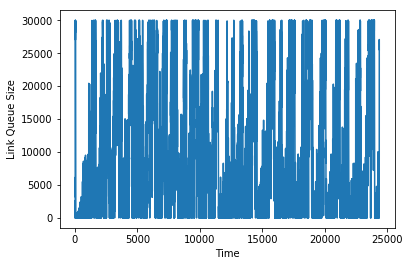

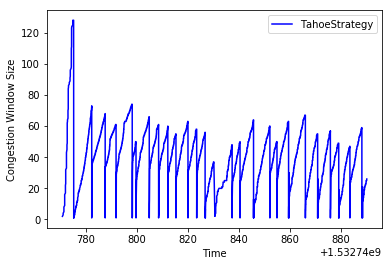

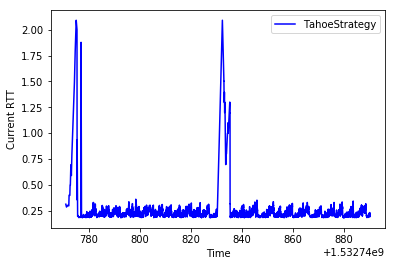

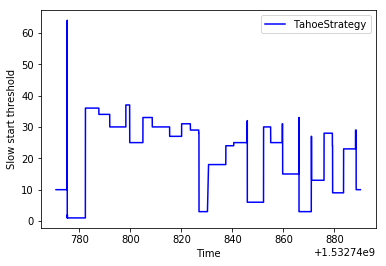

In [2]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}
port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# Low BDP Tahoe - RED

* **Throughput:** 14.2kbps
* **Average RTT:** 225.78ms

[sender] Connected to receiver: 100.64.0.2:49921

Results for sender 39682, with strategy: TahoeStrategy
**Throughput:**                           13778.000000 bytes/s
**Average RTT:**                          223.985913 ms



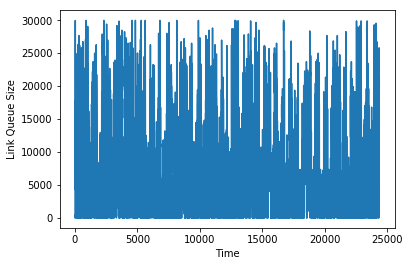

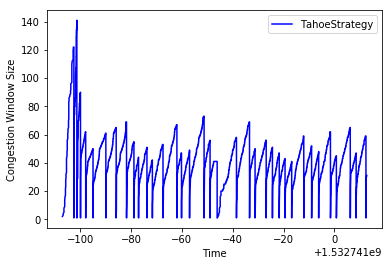

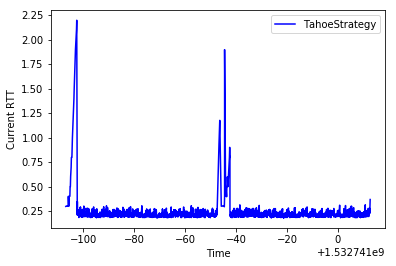

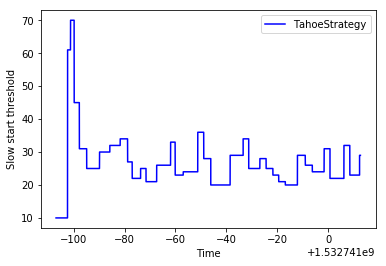

In [3]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'red',
    'downlink_queue_options': {
        'bytes': 30000,
        'wq': 0.002,
        'minthresh': 0.3,
        'maxthresh': 0.8
    }
}
port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# Low BDP CUBIC - Droptail

* **Throughput:** 13.81kbps
* **Average RTT:** 252.11ms

[sender] Connected to receiver: 100.64.0.2:34560

Results for sender 59582, with strategy: CubicStrategy
**Throughput:**                           14310.000000 bytes/s
**Average RTT:**                          253.462488 ms



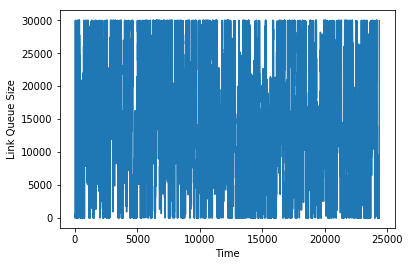

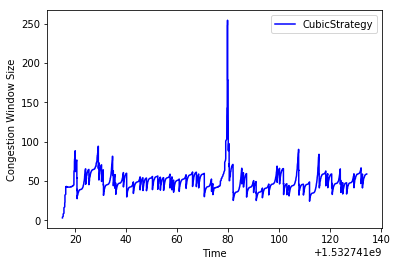

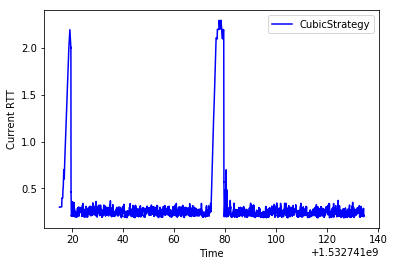

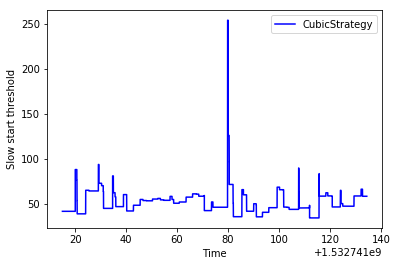

In [4]:
mahimahi_settings = {
    'delay': 88,
    'trace_file':'2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}
port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# Low BDP CUBIC - RED

* **Throughput:** 19.71kbps
* **Average RTT:** 238.46ms

[sender] Connected to receiver: 100.64.0.2:58450

Results for sender 51491, with strategy: CubicStrategy
**Throughput:**                           19199.333333 bytes/s
**Average RTT:**                          238.538155 ms



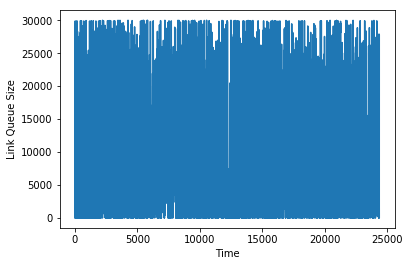

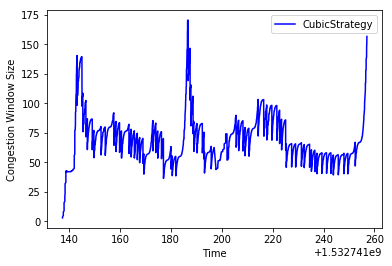

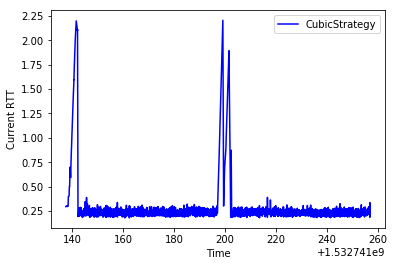

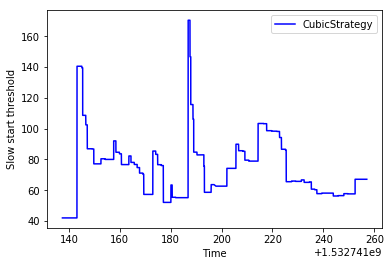

In [5]:

mahimahi_settings = {
    'delay': 88,
    'trace_file':'2.64mbps-poisson.trace',
    'queue_type': 'red',
    'downlink_queue_options': {
        'bytes': 30000,
        'wq': 0.002,
        'minthresh': 0.3,
        'maxthresh': 0.8
    }
}
port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# High BDP CUBIC - Droptail

* **Throughput:** 16.69kbps
* **Average RTT:** 448.26ms

[sender] Connected to receiver: 100.64.0.2:49903

Results for sender 49030, with strategy: CubicStrategy
**Throughput:**                           16534.000000 bytes/s
**Average RTT:**                          443.332488 ms



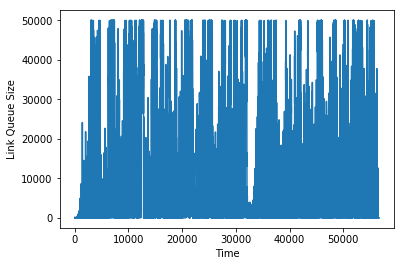

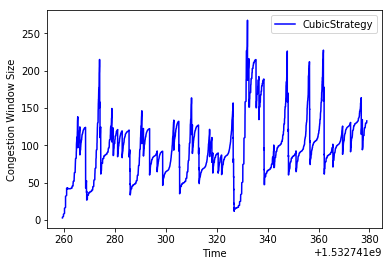

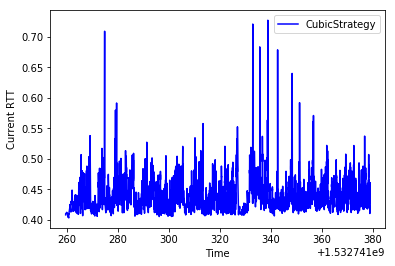

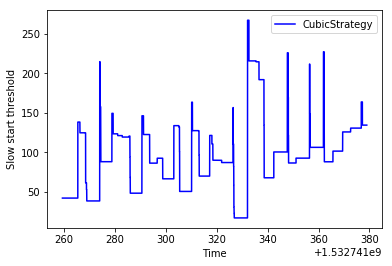

In [6]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}
port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# High BDP CUBIC - RED

* **Throughput:** 40.27kbps
* **Average RTT:** 489.93ms

[sender] Connected to receiver: 100.64.0.4:36856

Results for sender 41981, with strategy: CubicStrategy
**Throughput:**                           39878.666667 bytes/s
**Average RTT:**                          484.455220 ms



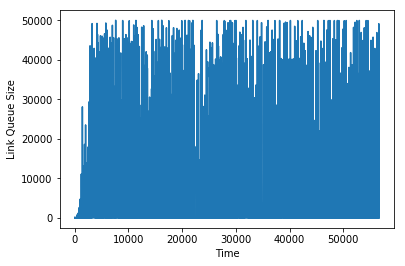

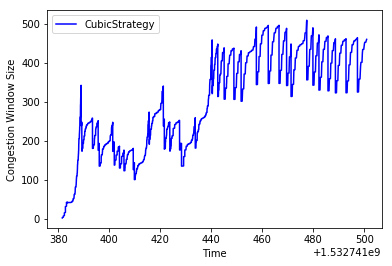

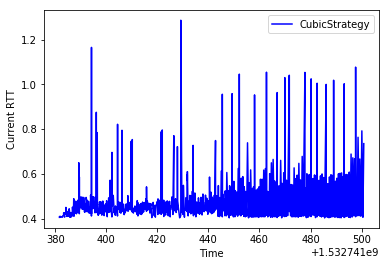

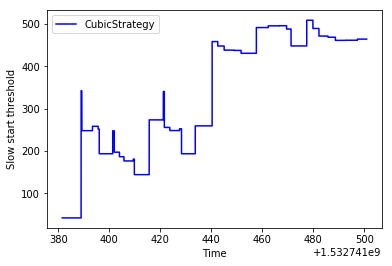

In [7]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'red',
    'downlink_queue_options': {
        'bytes': 50000,
        'wq': 0.002,
        'minthresh': 0.3,
        'maxthresh': 0.8
    }
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# High BDP Cubic vs Tahoe - Droptail

Tahoe:

* **Throughput:** 7.21kbps
* **Average RTT:** 506.19ms

CUBIC:

* **Throughput:** 44.16kbps
* **Average RTT:** 543.33ms

[sender] Connected to receiver: 100.64.0.2:40557

[sender] Connected to receiver: 100.64.0.2:40557

Results for sender 50295, with strategy: CubicStrategy
**Throughput:**                           35196.666667 bytes/s
**Average RTT:**                          537.993450 ms

Results for sender 50055, with strategy: TahoeStrategy
**Throughput:**                           7676.000000 bytes/s
**Average RTT:**                          452.689068 ms



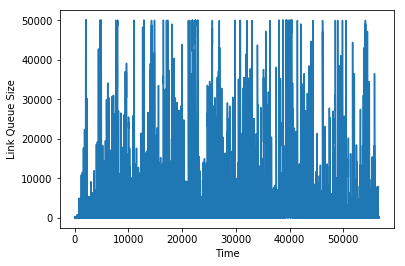

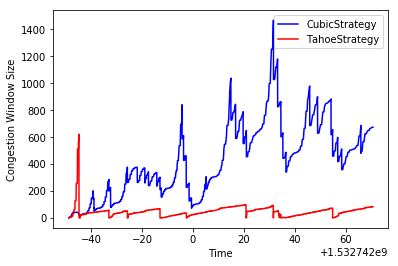

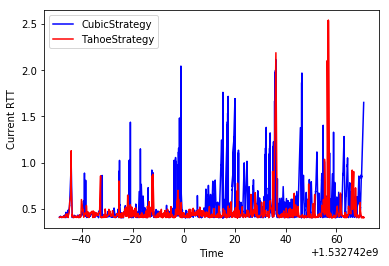

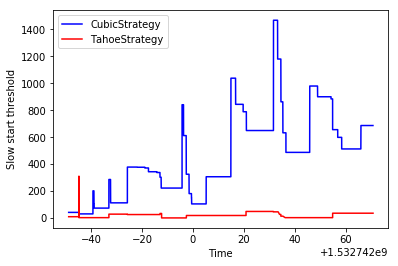

In [10]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port1 = get_open_udp_port()
strat1 = CubicStrategy(4)
port2 = get_open_udp_port()
strat2 = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])

# High BDP Cubic vs Tahoe - RED

Tahoe:

* **Throughput:** 7.32kbps
* **Average RTT:** 481.93ms

CUBIC:

* **Throughput:** 48.65kbps
* **Average RTT:** 537.62ms

[sender] Connected to receiver: 100.64.0.4:39709

[sender] Connected to receiver: 100.64.0.4:39709

Results for sender 37211, with strategy: CubicStrategy
**Throughput:**                           31723.333333 bytes/s
**Average RTT:**                          705.326789 ms

Results for sender 56759, with strategy: TahoeStrategy
**Throughput:**                           8787.333333 bytes/s
**Average RTT:**                          446.183465 ms



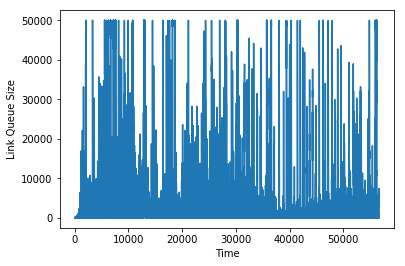

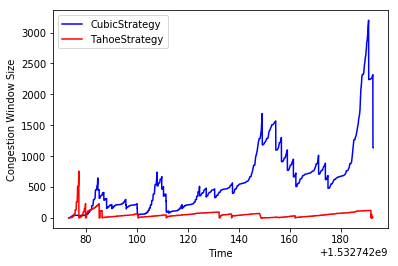

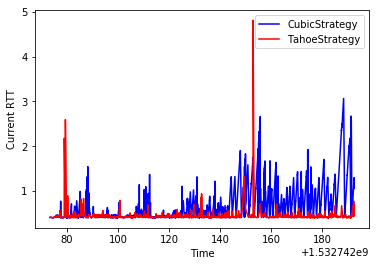

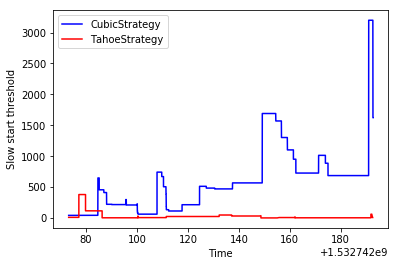

In [11]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000,
        'wq': 0.002,
        'minthresh': 0.3,
        'maxthresh': 0.8
    }
}

port1 = get_open_udp_port()
strat1 = CubicStrategy(4)
port2 = get_open_udp_port()
strat2 = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])